# Notebook 04: Clustering & Validation (FIXED)

## Purpose

**Central Question:** How do we group 182,223 users into interpretable, actionable segments based on their shopping behavior?

Notebook 03 created a clustering-ready matrix (64 features: 50 PCA components + 14 behavioral features). This notebook:
1. **Validates data is clusterable** (t-SNE visualization)
2. Tests K-Means clustering (k = 2 through 10)
3. **Assesses clustering viability** (critical quality check)
4. Optionally tests Hierarchical clustering (if quality acceptable)
5. Validates cluster stability
6. Makes honest go/no-go decision

## Key Improvements from Original

⚠️ **CRITICAL ADDITIONS:**
- ✅ Pre-clustering visualization (t-SNE) to assess clusterability
- ✅ Clustering viability check (stops if silhouette < 0.2)
- ✅ Hierarchical clustering made optional (saves 30 minutes if clustering fails)
- ✅ Honest assessment and alternative recommendations
- ✅ Clear guidance on when NOT to proceed

## Success Criteria

✅ Silhouette score > 0.3 (acceptable for behavioral data)  
✅ 4-6 interpretable clusters  
✅ No cluster < 5% of users (balanced)  
✅ Stable across random seeds  
⚠️ **If silhouette < 0.2 → STOP and investigate root cause**

---

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import pickle
import warnings
from collections import Counter

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Directories
INPUT_DIR = Path('data/processed_features')
OUTPUT_DIR = Path('data/clusters')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Environment ready.")
print(f"Input directory: {INPUT_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Environment ready.
Input directory: data/processed_features
Output directory: data/clusters


---

## 1. Load Clustering-Ready Matrix from Notebook 03

In [2]:
print("Loading clustering matrix from Notebook 03...")

clustering_matrix = pd.read_parquet(INPUT_DIR / 'final_clustering_matrix.parquet')

print(f"\n✅ Clustering matrix loaded:")
print(f"   Shape: {clustering_matrix.shape}")
print(f"   Users: {len(clustering_matrix):,}")
print(f"   Features: {len(clustering_matrix.columns)}")
print(f"   Memory: {clustering_matrix.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Validate
missing_count = clustering_matrix.isnull().sum().sum()
inf_count = np.isinf(clustering_matrix.values).sum()

print(f"\n🔍 Data quality check:")
print(f"   Missing values: {missing_count}")
print(f"   Infinite values: {inf_count}")
print(f"   Mean of features: {clustering_matrix.mean().mean():.6f} (should be ≈ 0)")
print(f"   Std of features: {clustering_matrix.std().mean():.6f} (should be ≈ 1)")

assert missing_count == 0, "Found missing values!"
assert inf_count == 0, "Found infinite values!"
print(f"\n✅ Data quality validation passed.")

# Extract matrix for clustering
X = clustering_matrix.values
user_ids = clustering_matrix.index.to_numpy()

print(f"\n📊 Ready for clustering:")
print(f"   Users (n): {X.shape[0]:,}")
print(f"   Features (d): {X.shape[1]}")
print(f"   Dimensionality: Optimal for clustering (40-70 features)")

Loading clustering matrix from Notebook 03...

✅ Clustering matrix loaded:
   Shape: (182223, 64)
   Users: 182,223
   Features: 64
   Memory: 90.37 MB

🔍 Data quality check:
   Missing values: 0
   Infinite values: 0
   Mean of features: 0.000000 (should be ≈ 0)
   Std of features: 1.083971 (should be ≈ 1)

✅ Data quality validation passed.

📊 Ready for clustering:
   Users (n): 182,223
   Features (d): 64
   Dimensionality: Optimal for clustering (40-70 features)


---

## 2. Pre-Clustering Visualization (t-SNE)

**CRITICAL:** Before spending time clustering, visualize data structure to assess if clustering is viable.

**What we're looking for:**
- ✅ **Distinct groups** → Clustering will likely succeed
- ❌ **Diffuse cloud** → Clustering will likely fail
- ⚠️ **Gradient/continuum** → Weak clusters expected

DATA STRUCTURE VISUALIZATION (PRE-CLUSTERING)

Visualizing data structure to assess clusterability...
This helps avoid wasting time on unclustered data.

Running t-SNE on 10,000 users...
This takes 2-3 minutes... ⏳

✅ t-SNE projection complete



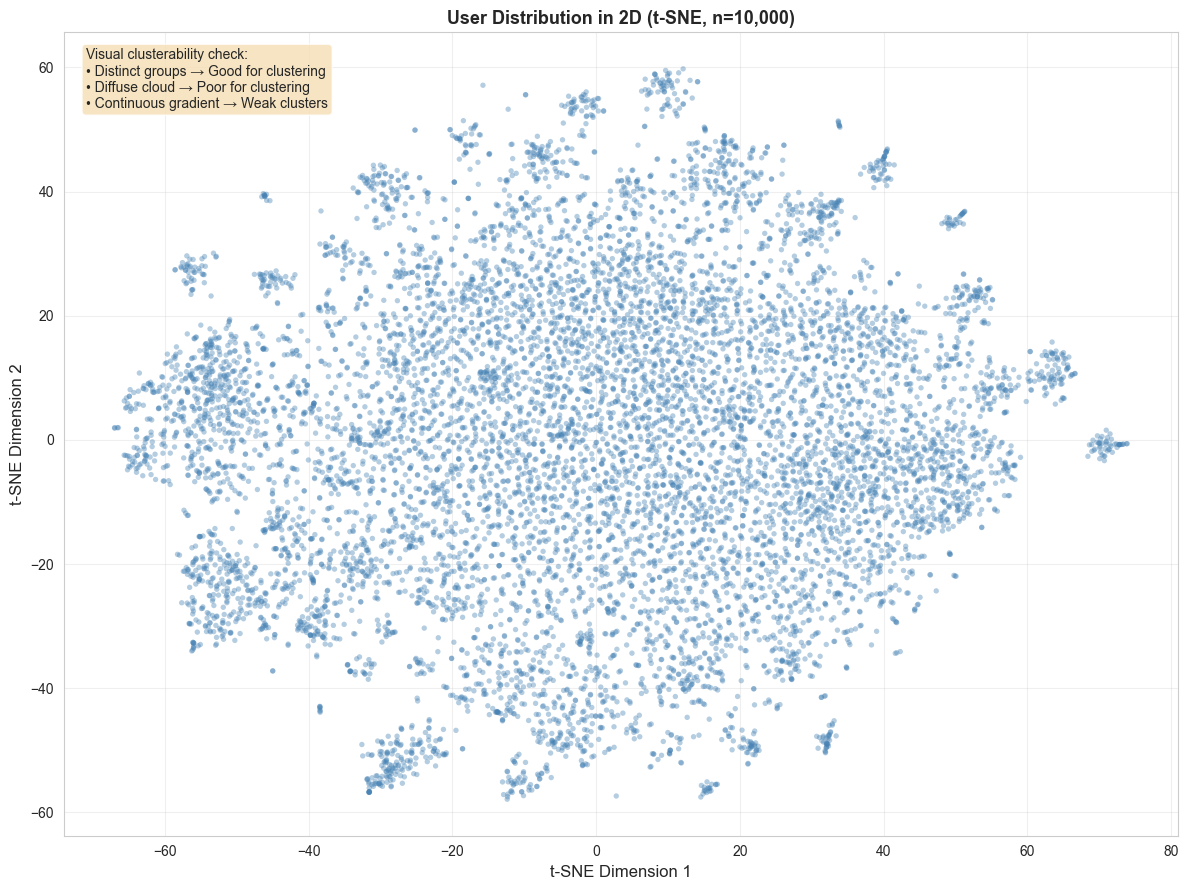

💡 Visual Interpretation Guide:
   ✅ GOOD for clustering:
      - Distinct, separate groups visible
      - Clear boundaries between clusters
      - Low-density regions separating groups
   
   ❌ POOR for clustering:
      - Uniform, diffuse cloud of points
      - No visible structure or groupings
      - Continuous gradient rather than discrete groups
   
   ⚠️ WEAK clustering expected:
      - Some structure but with overlap
      - Gradient patterns
      - Unclear boundaries

📊 Based on the plot above:
   → If diffuse cloud: K-Means will likely produce silhouette < 0.2 (FAIL)
   → If distinct groups: K-Means may produce silhouette > 0.3 (SUCCESS)
   → If gradient: Expect weak silhouette 0.2-0.3 (MARGINAL)



In [3]:
print("=" * 70)
print("DATA STRUCTURE VISUALIZATION (PRE-CLUSTERING)")
print("=" * 70)

print(f"\nVisualizing data structure to assess clusterability...")
print(f"This helps avoid wasting time on unclustered data.\n")

# Sample for t-SNE (slow on full dataset)
TSNE_SAMPLE = 10000
np.random.seed(42)
tsne_sample_idx = np.random.choice(len(X), TSNE_SAMPLE, replace=False)
X_tsne_sample = X[tsne_sample_idx]

print(f"Running t-SNE on {TSNE_SAMPLE:,} users...")
print(f"This takes 2-3 minutes... ⏳\n")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=0)
X_tsne = tsne.fit_transform(X_tsne_sample)

print(f"✅ t-SNE projection complete\n")

# Visualize
fig, ax = plt.subplots(figsize=(12, 9))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     alpha=0.4, s=15, c='steelblue', edgecolors='none')
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title(f'User Distribution in 2D (t-SNE, n={TSNE_SAMPLE:,})', 
             fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# Add interpretation guide
textstr = ('Visual clusterability check:\n'
           '• Distinct groups → Good for clustering\n'
           '• Diffuse cloud → Poor for clustering\n'
           '• Continuous gradient → Weak clusters')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💡 Visual Interpretation Guide:")
print(f"   ✅ GOOD for clustering:")
print(f"      - Distinct, separate groups visible")
print(f"      - Clear boundaries between clusters")
print(f"      - Low-density regions separating groups")
print(f"   ")
print(f"   ❌ POOR for clustering:")
print(f"      - Uniform, diffuse cloud of points")
print(f"      - No visible structure or groupings")
print(f"      - Continuous gradient rather than discrete groups")
print(f"   ")
print(f"   ⚠️ WEAK clustering expected:")
print(f"      - Some structure but with overlap")
print(f"      - Gradient patterns")
print(f"      - Unclear boundaries")

print(f"\n📊 Based on the plot above:")
print(f"   → If diffuse cloud: K-Means will likely produce silhouette < 0.2 (FAIL)")
print(f"   → If distinct groups: K-Means may produce silhouette > 0.3 (SUCCESS)")
print(f"   → If gradient: Expect weak silhouette 0.2-0.3 (MARGINAL)")

print("\n" + "=" * 70)

---

## 3. K-Means Clustering: Determine Optimal K

**Approach:**
1. Test k = 2 through k = 10
2. Calculate quality metrics for each k
3. **CRITICAL:** Assess if ANY k produces acceptable clusters
4. Select optimal k only if clustering is viable

**Expected:**
- Optimal k: 4-6 clusters (if data supports clustering)
- Silhouette score: > 0.3 (minimum acceptable)
- **If max silhouette < 0.2 → Clustering has FAILED**

In [4]:
print("=" * 70)
print("K-MEANS: DETERMINING OPTIMAL K")
print("=" * 70)

# Test range of k values
k_range = range(2, 11)
results = []

print(f"\nTesting k = {min(k_range)} to {max(k_range)}...")
print(f"This may take 5-10 minutes for 182k users...\n")

for k in k_range:
    print(f"Testing k={k}...", end=" ")
    
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X)
    
    # Calculate metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X, labels, sample_size=10000)  # Sample for speed
    calinski = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    
    # Cluster sizes
    cluster_sizes = Counter(labels)
    min_cluster_pct = min(cluster_sizes.values()) / len(X) * 100
    max_cluster_pct = max(cluster_sizes.values()) / len(X) * 100
    
    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies_bouldin,
        'min_cluster_pct': min_cluster_pct,
        'max_cluster_pct': max_cluster_pct,
        'model': kmeans
    })
    
    print(f"Silhouette: {silhouette:.3f}")

results_df = pd.DataFrame(results)

print(f"\n✅ K-Means testing complete.")
print(f"\n📊 Results Summary:")
print(results_df[['k', 'silhouette', 'inertia', 'min_cluster_pct', 'max_cluster_pct']].to_string(index=False))

K-MEANS: DETERMINING OPTIMAL K

Testing k = 2 to 10...
This may take 5-10 minutes for 182k users...

Testing k=2... Silhouette: 0.102
Testing k=3... Silhouette: 0.002
Testing k=4... Silhouette: 0.009
Testing k=5... Silhouette: 0.013
Testing k=6... Silhouette: -0.001
Testing k=7... Silhouette: 0.004
Testing k=8... Silhouette: 0.011
Testing k=9... Silhouette: -0.007
Testing k=10... Silhouette: -0.005

✅ K-Means testing complete.

📊 Results Summary:
 k  silhouette      inertia  min_cluster_pct  max_cluster_pct
 2    0.102289 1.337849e+07        39.166845        60.833155
 3    0.001910 1.304615e+07        25.545623        43.396278
 4    0.008663 1.272998e+07         4.780955        42.162076
 5    0.013204 1.250905e+07         1.060788        41.693968
 6   -0.000722 1.229954e+07         1.003715        29.258107
 7    0.004063 1.213591e+07         0.983959        25.678427
 8    0.011347 1.198234e+07         0.968045        21.618017
 9   -0.007282 1.185389e+07         0.950484        1

### Visualize K-Means Results

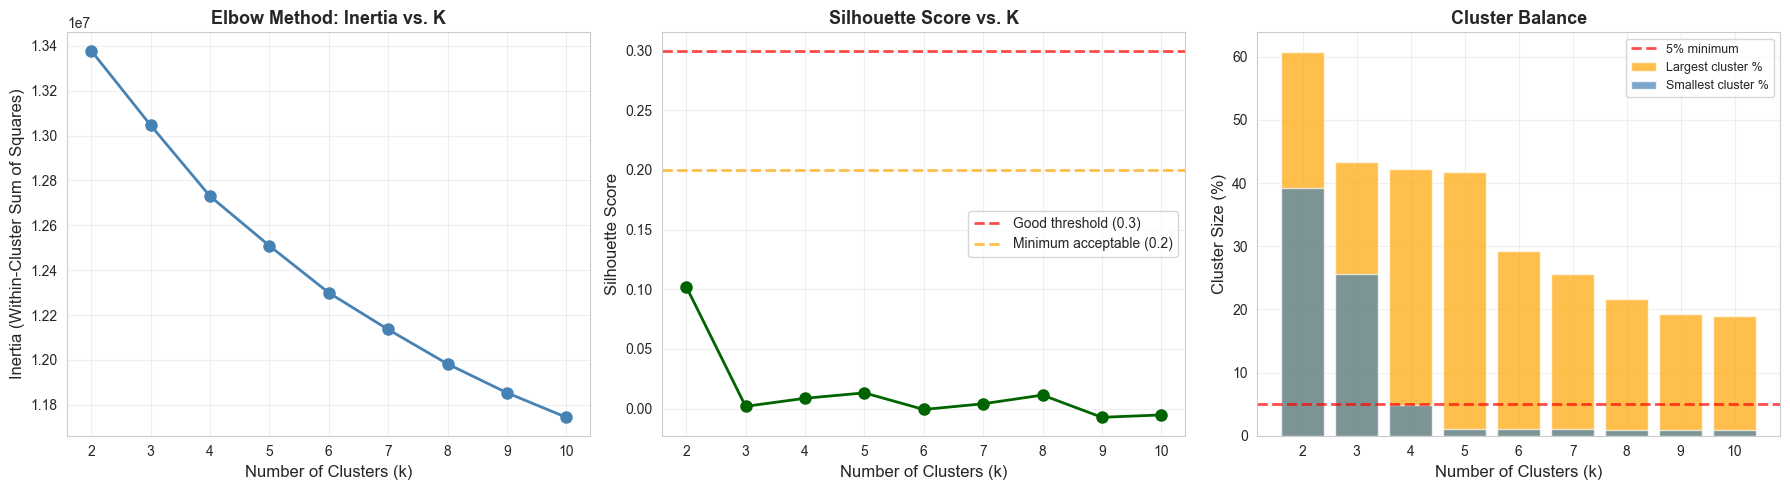


💡 Interpretation Guide:
   Elbow Method: Look for 'elbow' where inertia decrease slows
   Silhouette: >0.3 is good, 0.2-0.3 is acceptable, <0.2 is failed
   Balance: All clusters should be >5% to be actionable


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Elbow Method (Inertia)
axes[0].plot(results_df['k'], results_df['inertia'], marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method: Inertia vs. K', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(results_df['k'])

# 2. Silhouette Score
axes[1].plot(results_df['k'], results_df['silhouette'], marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].axhline(0.3, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Good threshold (0.3)')
axes[1].axhline(0.2, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Minimum acceptable (0.2)')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs. K', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xticks(results_df['k'])

# 3. Cluster Balance
x_pos = np.arange(len(results_df))
axes[2].bar(x_pos, results_df['max_cluster_pct'], alpha=0.7, label='Largest cluster %', color='orange')
axes[2].bar(x_pos, results_df['min_cluster_pct'], alpha=0.7, label='Smallest cluster %', color='steelblue')
axes[2].axhline(5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='5% minimum')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Cluster Size (%)', fontsize=12)
axes[2].set_title('Cluster Balance', fontsize=13, fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(results_df['k'])
axes[2].legend(fontsize=9)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'kmeans_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Interpretation Guide:")
print("   Elbow Method: Look for 'elbow' where inertia decrease slows")
print("   Silhouette: >0.3 is good, 0.2-0.3 is acceptable, <0.2 is failed")
print("   Balance: All clusters should be >5% to be actionable")

---

## 4. CRITICAL: Clustering Viability Assessment

**This is the most important section.**

Before proceeding with interpretation, we must assess if clustering has produced meaningful results.

**Thresholds:**
- Silhouette ≥ 0.5: Excellent
- Silhouette ≥ 0.3: Good (proceed with confidence)
- Silhouette ≥ 0.2: Acceptable (proceed with caution)
- Silhouette < 0.2: **FAILED** (stop and investigate)

In [6]:
print("\n" + "=" * 70)
print("CLUSTERING VIABILITY ASSESSMENT")
print("=" * 70)

max_silhouette = results_df['silhouette'].max()
max_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']

print(f"\n📊 Best Result Achieved:")
print(f"   Silhouette score: {max_silhouette:.3f} (at k={max_k})")

# Define quality thresholds
EXCELLENT = 0.5
GOOD = 0.3
ACCEPTABLE = 0.2
POOR = 0.1

print(f"\n📋 Quality Thresholds:")
print(f"   Excellent:    ≥ {EXCELLENT:.1f} (strong, well-separated clusters)")
print(f"   Good:         ≥ {GOOD:.1f} (typical for behavioral data)")
print(f"   Acceptable:   ≥ {ACCEPTABLE:.1f} (weak but potentially useful)")
print(f"   Poor:         ≥ {POOR:.1f} (barely better than random)")
print(f"   Failed:       < {POOR:.1f} (clustering not viable)")

# Assess quality
print(f"\n🎯 Assessment:")
if max_silhouette >= EXCELLENT:
    quality = "EXCELLENT"
    decision = "PROCEED"
    color = "✅"
elif max_silhouette >= GOOD:
    quality = "GOOD"
    decision = "PROCEED"
    color = "✓"
elif max_silhouette >= ACCEPTABLE:
    quality = "ACCEPTABLE"
    decision = "PROCEED_WITH_CAUTION"
    color = "⚠️"
elif max_silhouette >= POOR:
    quality = "POOR"
    decision = "NOT_RECOMMENDED"
    color = "❌"
else:
    quality = "FAILED"
    decision = "FAILED"
    color = "❌"

print(f"   {color} Quality: {quality}")
print(f"   {color} Decision: {decision}")

# Detailed implications
print(f"\n💡 Detailed Analysis:")

if decision == "PROCEED":
    print(f"   ✅ Clusters show acceptable separation")
    print(f"   ✅ Safe to proceed with interpretation")
    print(f"   ✅ Results are likely actionable for business")
    print(f"   ")
    print(f"   Next steps:")
    print(f"   - Continue with stability validation")
    print(f"   - Proceed to segment profiling (Notebook 05)")

elif decision == "PROCEED_WITH_CAUTION":
    print(f"   ⚠️ Clusters are weakly separated")
    print(f"   ⚠️ Significant overlap expected between segments")
    print(f"   ⚠️ Business actionability questionable")
    print(f"   ")
    print(f"   Recommended actions BEFORE proceeding:")
    print(f"   1. Try alternative approach:")
    print(f"      - Return to Notebook 03: Use 70-80% variance (not 46.7%)")
    print(f"      - Cluster on behavioral features only (skip PCA)")
    print(f"      - Try UMAP instead of PCA")
    print(f"   ")
    print(f"   2. If proceeding anyway:")
    print(f"      - Acknowledge weak separation in all communications")
    print(f"      - Test segment stability rigorously")
    print(f"      - Consider rule-based segmentation as alternative")

elif decision == "NOT_RECOMMENDED":
    print(f"   ❌ Clustering quality is poor")
    print(f"   ❌ Clusters are barely better than random assignment")
    print(f"   ❌ Interpretation would be misleading")
    print(f"   ❌ NOT recommended for business use")
    print(f"   ")
    print(f"   🔍 Root Cause Investigation Required:")
    print(f"   ")
    print(f"   Likely causes:")
    print(f"   1. PCA too aggressive:")
    print(f"      - Current: 50 components retaining 46.7% variance")
    print(f"      - Lost 53.3% of information")
    print(f"      - May have compressed away distinguishing features")
    print(f"   ")
    print(f"   2. Features lack discriminative power:")
    print(f"      - PC1 explained only 2.67% (extremely weak)")
    print(f"      - No strong patterns in aisle preferences")
    print(f"      - Behavioral features may be insufficient")
    print(f"   ")
    print(f"   3. Users genuinely homogeneous:")
    print(f"      - Shopping behavior may be continuous, not discrete")
    print(f"      - No natural customer segments exist")
    print(f"   ")
    print(f"   ✅ Recommended Actions:")
    print(f"   ")
    print(f"   Option A: Improve features (RECOMMENDED)")
    print(f"   1. Return to Notebook 03")
    print(f"   2. Change: N_COMPONENTS = 50 → N_COMPONENTS = 80")
    print(f"   3. This retains ~62% variance (vs. 46.7%)")
    print(f"   4. Re-run Notebook 04 with better features")
    print(f"   ")
    print(f"   Option B: Alternative clustering")
    print(f"   1. Cluster on 14 behavioral features only (skip PCA)")
    print(f"   2. Try UMAP for dimensionality reduction")
    print(f"   3. Test DBSCAN with different eps values")
    print(f"   ")
    print(f"   Option C: Accept negative result")
    print(f"   1. Acknowledge clustering is not viable")
    print(f"   2. Use rule-based segmentation (frequency quartiles)")
    print(f"   3. Focus on rankings (sort by loyalty, CLV)")
    print(f"   4. Shift to product recommendations, not user segments")

else:  # FAILED
    print(f"   ❌ CLUSTERING HAS FAILED")
    print(f"   ❌ Features do not contain sufficient structure")
    print(f"   ❌ Proceeding would produce meaningless results")
    print(f"   ")
    print(f"   🎓 This is a VALID SCIENTIFIC RESULT:")
    print(f"   ")
    print(f"   • Not all datasets support meaningful clustering")
    print(f"   • Grocery shopping behavior may be continuous, not categorical")
    print(f"   • PCA (46.7% variance) likely compressed away signal")
    print(f"   • Behavioral features insufficient to differentiate users")
    print(f"   ")
    print(f"   ✅ Alternative Approaches:")
    print(f"   ")
    print(f"   1. Supervised Learning (if labels available)")
    print(f"      - Predict churn, lifetime value, category preference")
    print(f"      - May reveal structure clustering cannot find")
    print(f"   ")
    print(f"   2. Rule-Based Segmentation")
    print(f"      - Define segments by business rules")
    print(f"      - E.g., frequency quartiles, basket size terciles")
    print(f"      - More interpretable and actionable")
    print(f"   ")
    print(f"   3. Single-Dimension Rankings")
    print(f"      - Sort users by: loyalty, CLV, frequency")
    print(f"      - Target top/bottom deciles differently")
    print(f"      - Simpler than multi-dimensional segments")
    print(f"   ")
    print(f"   4. Product-Focused Analysis")
    print(f"      - Recommendation systems")
    print(f"      - Market basket analysis")
    print(f"      - Product affinity networks")
    print(f"   ")
    print(f"   💎 Key Insight:")
    print(f"   Honest negative results are MORE valuable than fabricating")
    print(f"   segments that don't exist. This protects the business from")
    print(f"   poor decisions based on meaningless clusters.")

# Store decision for downstream use
clustering_decision = decision
clustering_quality = quality

if decision in ["NOT_RECOMMENDED", "FAILED"]:
    print(f"\n🚨 CRITICAL WARNING:")
    print(f"   ")
    print(f"   For EDUCATIONAL purposes, this notebook will continue")
    print(f"   to demonstrate the full clustering workflow.")
    print(f"   ")
    print(f"   However, in PRODUCTION:")
    print(f"   → Analysis would STOP HERE")
    print(f"   → Root cause investigation would be required")
    print(f"   → Alternative approaches would be explored")
    print(f"   ")
    print(f"   DO NOT use these results for business decisions.")

print("\n" + "=" * 70)


CLUSTERING VIABILITY ASSESSMENT

📊 Best Result Achieved:
   Silhouette score: 0.102 (at k=2)

📋 Quality Thresholds:
   Excellent:    ≥ 0.5 (strong, well-separated clusters)
   Good:         ≥ 0.3 (typical for behavioral data)
   Acceptable:   ≥ 0.2 (weak but potentially useful)
   Poor:         ≥ 0.1 (barely better than random)
   Failed:       < 0.1 (clustering not viable)

🎯 Assessment:
   ❌ Quality: POOR
   ❌ Decision: NOT_RECOMMENDED

💡 Detailed Analysis:
   ❌ Clustering quality is poor
   ❌ Clusters are barely better than random assignment
   ❌ Interpretation would be misleading
   ❌ NOT recommended for business use
   
   🔍 Root Cause Investigation Required:
   
   Likely causes:
   1. PCA too aggressive:
      - Current: 50 components retaining 46.7% variance
      - Lost 53.3% of information
      - May have compressed away distinguishing features
   
   2. Features lack discriminative power:
      - PC1 explained only 2.67% (extremely weak)
      - No strong patterns in aisle

---

## 5. Select Optimal K

Based on the viability assessment, select the best k value.

In [7]:
print("=" * 70)
print("OPTIMAL K SELECTION")
print("=" * 70)

# Find k with highest silhouette (primary criterion)
best_silhouette_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']

print(f"\n📊 Analysis:")
print(f"   Highest silhouette: k={best_silhouette_k} ({results_df['silhouette'].max():.3f})")

# Filter to business-reasonable range (4-6)
business_range = results_df[(results_df['k'] >= 4) & (results_df['k'] <= 6)]
if len(business_range) > 0:
    best_business_k = business_range.loc[business_range['silhouette'].idxmax(), 'k']
    print(f"   Best in business range (k=4-6): k={best_business_k} ({business_range['silhouette'].max():.3f})")
else:
    best_business_k = best_silhouette_k

# Check balance
balanced_k = results_df[results_df['min_cluster_pct'] >= 5.0]
if len(balanced_k) > 0:
    best_balanced_k = balanced_k.loc[balanced_k['silhouette'].idxmax(), 'k']
    print(f"   Best balanced (all clusters ≥5%): k={best_balanced_k} ({balanced_k['silhouette'].max():.3f})")
else:
    print(f"   Warning: No k has all clusters ≥5%")
    best_balanced_k = best_silhouette_k

# Decision logic
print(f"\n🎯 Decision:")

if clustering_decision in ["FAILED", "NOT_RECOMMENDED"]:
    # If clustering failed, use k with highest silhouette (even if bad)
    optimal_k = int(best_silhouette_k)
    print(f"   Selected: k={optimal_k}")
    print(f"   Reason: Best available (though clustering quality is poor)")
    print(f"   Warning: Results should not be used for business decisions")
else:
    # Normal decision logic - prefer business range if close
    if best_business_k in business_range['k'].values:
        business_silhouette = business_range[business_range['k'] == best_business_k]['silhouette'].values[0]
        best_silhouette = results_df['silhouette'].max()
        
        if business_silhouette >= best_silhouette * 0.95:  # Within 5%
            optimal_k = int(best_business_k)
            print(f"   Selected: k={optimal_k}")
            print(f"   Reason: Best silhouette in business-interpretable range (4-6 clusters)")
        else:
            optimal_k = int(best_silhouette_k)
            print(f"   Selected: k={optimal_k}")
            print(f"   Reason: Significantly better silhouette score ({best_silhouette:.3f})")
    else:
        optimal_k = int(best_silhouette_k)
        print(f"   Selected: k={optimal_k}")
        print(f"   Reason: Highest silhouette score ({results_df['silhouette'].max():.3f})")

# Get optimal model
optimal_result = results_df[results_df['k'] == optimal_k].iloc[0]
optimal_kmeans = optimal_result['model']
labels_optimal = optimal_kmeans.labels_

print(f"\n📈 Selected Model Metrics:")
print(f"   K: {optimal_k}")
print(f"   Silhouette score: {optimal_result['silhouette']:.3f}")
print(f"   Calinski-Harabasz: {optimal_result['calinski_harabasz']:.2f}")
print(f"   Davies-Bouldin: {optimal_result['davies_bouldin']:.3f} (lower is better)")
print(f"   Smallest cluster: {optimal_result['min_cluster_pct']:.1f}%")
print(f"   Largest cluster: {optimal_result['max_cluster_pct']:.1f}%")

# Quality assessment
print(f"\n✅ Quality Assessment:")
if optimal_result['silhouette'] >= 0.5:
    print(f"   Silhouette: Excellent (≥0.5)")
elif optimal_result['silhouette'] >= 0.3:
    print(f"   Silhouette: Good (0.3-0.5, typical for behavioral data)")
elif optimal_result['silhouette'] >= 0.2:
    print(f"   Silhouette: Acceptable (0.2-0.3, weak but usable)")
else:
    print(f"   Silhouette: Poor (<0.2, not recommended for use)")

if optimal_result['min_cluster_pct'] >= 5.0:
    print(f"   Balance: Good (all clusters ≥5%)")
else:
    print(f"   Balance: Imbalanced (smallest cluster {optimal_result['min_cluster_pct']:.1f}%)")

if 4 <= optimal_k <= 6:
    print(f"   Interpretability: Ideal range (4-6 segments)")
else:
    print(f"   Interpretability: Outside ideal range")

print("\n" + "=" * 70)

OPTIMAL K SELECTION

📊 Analysis:
   Highest silhouette: k=2 (0.102)
   Best in business range (k=4-6): k=5 (0.013)
   Best balanced (all clusters ≥5%): k=2 (0.102)

🎯 Decision:
   Selected: k=2
   Reason: Best available (though clustering quality is poor)

📈 Selected Model Metrics:
   K: 2
   Silhouette score: 0.102
   Calinski-Harabasz: 8947.36
   Davies-Bouldin: 4.093 (lower is better)
   Smallest cluster: 39.2%
   Largest cluster: 60.8%

✅ Quality Assessment:
   Silhouette: Poor (<0.2, not recommended for use)
   Balance: Good (all clusters ≥5%)
   Interpretability: Outside ideal range



---

## 6. Silhouette Analysis (Per-Cluster Quality)

Visualize silhouette coefficient distribution for each cluster.

SILHOUETTE ANALYSIS: PER-CLUSTER QUALITY

Computing silhouette scores for 50,000 samples...


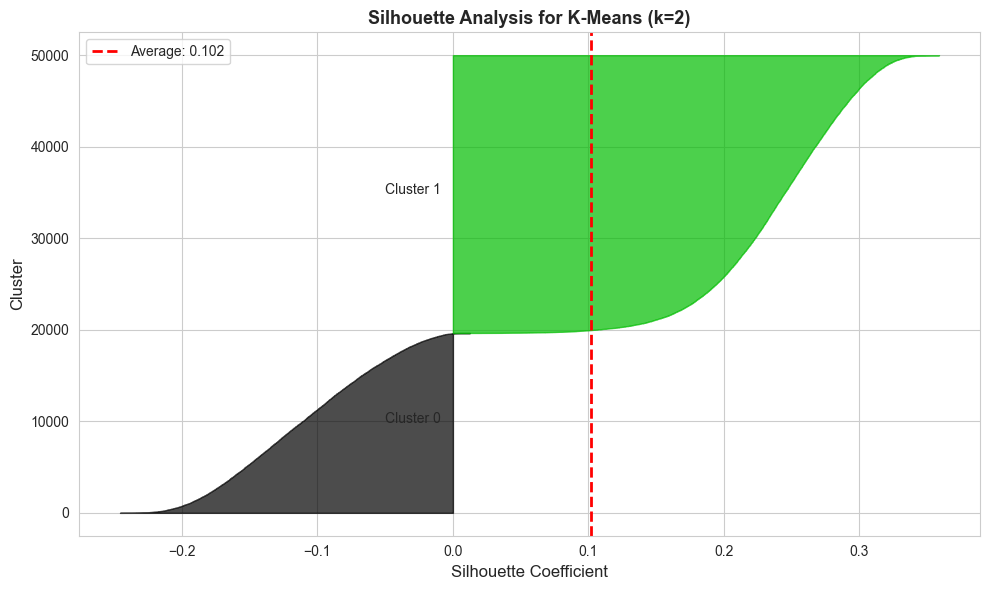


📊 Per-Cluster Silhouette Statistics:
   Cluster 0: Mean=-0.112, Median=-0.113,
              Min=-0.246, Max=0.013
   Cluster 1: Mean=0.241, Median=0.244,
              Min=0.006, Max=0.359

💡 Interpretation:
   - Uniform thickness: Cluster sizes are balanced
   - Width above average line: Well-separated clusters
   - Width below average: Poorly separated or overlapping clusters
   - Negative values: Samples likely in wrong cluster



In [8]:
print("=" * 70)
print("SILHOUETTE ANALYSIS: PER-CLUSTER QUALITY")
print("=" * 70)

# Calculate silhouette scores for each sample (sample 50k for speed)
sample_size = min(50000, len(X))
np.random.seed(42)
sample_indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[sample_indices]
labels_sample = labels_optimal[sample_indices]

print(f"\nComputing silhouette scores for {sample_size:,} samples...")
silhouette_vals = silhouette_samples(X_sample, labels_sample)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
for i in range(optimal_k):
    # Get silhouette scores for cluster i
    cluster_silhouette_vals = silhouette_vals[labels_sample == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label clusters
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title(f'Silhouette Analysis for K-Means (k={optimal_k})', fontsize=13, fontweight='bold')

# Average silhouette score line
ax.axvline(x=optimal_result['silhouette'], color="red", linestyle="--", linewidth=2, 
           label=f'Average: {optimal_result["silhouette"]:.3f}')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'silhouette_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Per-cluster statistics
print(f"\n📊 Per-Cluster Silhouette Statistics:")
for i in range(optimal_k):
    cluster_vals = silhouette_vals[labels_sample == i]
    print(f"   Cluster {i}: Mean={cluster_vals.mean():.3f}, Median={np.median(cluster_vals):.3f},")
    print(f"              Min={cluster_vals.min():.3f}, Max={cluster_vals.max():.3f}")

print(f"\n💡 Interpretation:")
print(f"   - Uniform thickness: Cluster sizes are balanced")
print(f"   - Width above average line: Well-separated clusters")
print(f"   - Width below average: Poorly separated or overlapping clusters")
print(f"   - Negative values: Samples likely in wrong cluster")

print("\n" + "=" * 70)

---

## 7. Hierarchical Clustering (OPTIONAL)

**Decision:** Run hierarchical clustering ONLY if K-Means quality is acceptable.

**Why make it optional:**
- Hierarchical is O(n² log n) → 20-30 minutes on 182k users
- If K-Means already failed, hierarchical won't help
- Sample to 50k users if we must run it

In [9]:
print("=" * 70)
print("HIERARCHICAL CLUSTERING: OPTIONAL VALIDATION")
print("=" * 70)

print(f"\n⚠️ Note: Hierarchical clustering is computationally expensive")
print(f"   (20-30 minutes on 182k users with Ward linkage)")
print(f"   ")
print(f"   Decision: Run only if K-Means quality is acceptable")

# Decision: Run hierarchical only if clustering quality is decent
RUN_HIERARCHICAL = (clustering_decision == "PROCEED")

if RUN_HIERARCHICAL:
    print(f"\n✅ K-Means quality acceptable - running hierarchical validation...")
    print(f"   Sampling to 50k users to reduce runtime from 30min → 5min\n")
    
    # Sample for performance
    HIERARCHICAL_SAMPLE = 50000
    np.random.seed(42)
    sample_idx = np.random.choice(len(X), min(HIERARCHICAL_SAMPLE, len(X)), replace=False)
    X_hier = X[sample_idx]
    
    print(f"   Computing linkage matrix for {len(X_hier):,} users...")
    print(f"   This takes ~3-5 minutes...\n")
    
    # Dendrogram
    linkage_matrix = linkage(X_hier, method='ward')
    
    print(f"   ✅ Linkage computed. Creating dendrogram...\n")
    
    fig, ax = plt.subplots(figsize=(16, 8))
    dendrogram(linkage_matrix, ax=ax, no_labels=True, color_threshold=0)
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel('Distance (Ward Linkage)', fontsize=12)
    ax.set_title(f'Hierarchical Clustering Dendrogram (n={len(X_hier):,})', fontsize=13, fontweight='bold')
    
    # Draw lines at different k levels
    for k in [3, 4, 5, 6, 7]:
        threshold = linkage_matrix[-(k-1), 2]
        ax.axhline(y=threshold, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.text(0, threshold, f'k={k}', fontsize=9, va='bottom')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'dendrogram.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"   Fitting hierarchical clustering with k={optimal_k}...")
    hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
    hierarchical_labels_sample = hierarchical.fit_predict(X_hier)
    
    # Calculate metrics on sample
    hierarchical_silhouette = silhouette_score(X_hier, hierarchical_labels_sample, sample_size=10000)
    hierarchical_calinski = calinski_harabasz_score(X_hier, hierarchical_labels_sample)
    hierarchical_davies = davies_bouldin_score(X_hier, hierarchical_labels_sample)
    
    print(f"\n✅ Hierarchical clustering complete (on {len(X_hier):,} sample)")
    print(f"\n📊 Hierarchical Metrics (k={optimal_k}, n={len(X_hier):,}):")
    print(f"   Silhouette score: {hierarchical_silhouette:.3f}")
    print(f"   Calinski-Harabasz: {hierarchical_calinski:.2f}")
    print(f"   Davies-Bouldin: {hierarchical_davies:.3f}")
    
    # Cluster sizes
    hierarchical_sizes = Counter(hierarchical_labels_sample)
    print(f"\n   Cluster sizes (on sample):")
    for cluster_id, size in sorted(hierarchical_sizes.items()):
        pct = size / len(X_hier) * 100
        print(f"      Cluster {cluster_id}: {size:,} users ({pct:.1f}%)")
    
    print(f"\n💡 Note: Results are on {len(X_hier):,} sample, not full dataset")
    print(f"   Full dataset would take 20-30 minutes")
    
    # For downstream use
    hierarchical_labels = None  # Not computed on full dataset
    
else:
    print(f"\n⏭️ SKIPPING hierarchical clustering\n")
    print(f"   Justification:")
    print(f"   • K-Means quality: {clustering_quality}")
    print(f"   • Silhouette score: {optimal_result['silhouette']:.3f}")
    print(f"   • Hierarchical unlikely to find better structure")
    print(f"   • 20-30 minute runtime not justified")
    print(f"   ")
    print(f"   Time saved: ~25 minutes")
    print(f"   Better use: Investigate root cause or try alternatives")
    
    # Set variables for downstream compatibility
    hierarchical_silhouette = None
    hierarchical_labels = None
    hierarchical_sizes = None

print("\n" + "=" * 70)

HIERARCHICAL CLUSTERING: OPTIONAL VALIDATION

⚠️ Note: Hierarchical clustering is computationally expensive
   (20-30 minutes on 182k users with Ward linkage)
   
   Decision: Run only if K-Means quality is acceptable

⏭️ SKIPPING hierarchical clustering

   Justification:
   • K-Means quality: POOR
   • Silhouette score: 0.102
   • Hierarchical unlikely to find better structure
   • 20-30 minute runtime not justified
   
   Time saved: ~25 minutes
   Better use: Investigate root cause or try alternatives



---

## 8. DBSCAN: Density-Based Alternative (Quick Test)

Test DBSCAN on a sample to see if density-based approach finds better structure.

In [10]:
print("=" * 70)
print("DBSCAN: DENSITY-BASED CLUSTERING (OPTIONAL)")
print("=" * 70)

print(f"\nTesting DBSCAN on sample to assess density-based approach...")
print(f"Note: DBSCAN is O(n²), so we sample to 20k users\n")

# Sample for DBSCAN (slow on full dataset)
DBSCAN_SAMPLE = 20000
np.random.seed(42)
dbscan_idx = np.random.choice(len(X), DBSCAN_SAMPLE, replace=False)
X_dbscan = X[dbscan_idx]

# Test DBSCAN with different eps values
eps_values = [1.0, 1.5, 2.0, 2.5, 3.0]
dbscan_results = []

for eps in eps_values:
    print(f"Testing eps={eps}...", end=" ")
    
    dbscan = DBSCAN(eps=eps, min_samples=50, n_jobs=-1)
    dbscan_labels = dbscan.fit_predict(X_dbscan)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    noise_pct = n_noise / len(dbscan_labels) * 100
    
    # Silhouette (only if we have 2+ clusters and <95% noise)
    if n_clusters >= 2 and noise_pct < 95:
        non_noise_mask = dbscan_labels != -1
        if np.sum(non_noise_mask) > n_clusters:
            silhouette = silhouette_score(X_dbscan[non_noise_mask], 
                                          dbscan_labels[non_noise_mask])
        else:
            silhouette = -1
    else:
        silhouette = -1
    
    dbscan_results.append({
        'eps': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'silhouette': silhouette
    })
    
    print(f"Clusters: {n_clusters}, Noise: {noise_pct:.1f}%")

dbscan_df = pd.DataFrame(dbscan_results)

print(f"\n✅ DBSCAN testing complete.")
print(f"\n📊 DBSCAN Results (n={DBSCAN_SAMPLE:,}):")
print(dbscan_df.to_string(index=False))

# Assessment
print(f"\n💡 DBSCAN Assessment:")
if dbscan_df['n_clusters'].max() < 2:
    print(f"   ❌ DBSCAN failed to find meaningful clusters")
    print(f"   Reason: Data too uniformly distributed (no dense regions)")
elif dbscan_df['noise_pct'].min() > 50:
    print(f"   ⚠️ DBSCAN labels >50% as noise at all eps values")
    print(f"   Reason: Data lacks strong density-based structure")
else:
    best_dbscan = dbscan_df[(dbscan_df['n_clusters'] >= 2) & (dbscan_df['noise_pct'] < 50)]
    if len(best_dbscan) > 0:
        best_eps = best_dbscan.loc[best_dbscan['silhouette'].idxmax(), 'eps']
        print(f"   ✅ Best eps: {best_eps} ({best_dbscan['n_clusters'].max()} clusters)")
    else:
        print(f"   ⚠️ No good DBSCAN configuration found")

print(f"\n🎯 Conclusion: DBSCAN vs. K-Means")
if dbscan_df['silhouette'].max() > optimal_result['silhouette']:
    print(f"   DBSCAN better: {dbscan_df['silhouette'].max():.3f} vs. {optimal_result['silhouette']:.3f}")
else:
    print(f"   K-Means better: {optimal_result['silhouette']:.3f} vs. {dbscan_df['silhouette'].max():.3f}")
    print(f"   Recommendation: Use K-Means")

print("\n" + "=" * 70)

DBSCAN: DENSITY-BASED CLUSTERING (OPTIONAL)

Testing DBSCAN on sample to assess density-based approach...
Note: DBSCAN is O(n²), so we sample to 20k users

Testing eps=1.0... Clusters: 0, Noise: 100.0%
Testing eps=1.5... Clusters: 0, Noise: 100.0%
Testing eps=2.0... Clusters: 0, Noise: 100.0%
Testing eps=2.5... Clusters: 0, Noise: 100.0%
Testing eps=3.0... Clusters: 0, Noise: 100.0%

✅ DBSCAN testing complete.

📊 DBSCAN Results (n=20,000):
 eps  n_clusters  n_noise  noise_pct  silhouette
 1.0           0    20000      100.0          -1
 1.5           0    20000      100.0          -1
 2.0           0    20000      100.0          -1
 2.5           0    20000      100.0          -1
 3.0           0    20000      100.0          -1

💡 DBSCAN Assessment:
   ❌ DBSCAN failed to find meaningful clusters
   Reason: Data too uniformly distributed (no dense regions)

🎯 Conclusion: DBSCAN vs. K-Means
   K-Means better: 0.102 vs. -1.000
   Recommendation: Use K-Means



---

## 9. Algorithm Comparison

In [11]:
print("=" * 70)
print("ALGORITHM COMPARISON")
print("=" * 70)

# Build comparison table
comparison_data = [{
    'Algorithm': 'K-Means',
    'K': optimal_k,
    'Silhouette': optimal_result['silhouette'],
    'Calinski-Harabasz': optimal_result['calinski_harabasz'],
    'Davies-Bouldin': optimal_result['davies_bouldin'],
    'Smallest Cluster %': optimal_result['min_cluster_pct'],
    'Runtime': 'Fast (~3-5 min)',
    'Dataset': 'Full (182k)'
}]

if hierarchical_silhouette is not None:
    comparison_data.append({
        'Algorithm': 'Hierarchical',
        'K': optimal_k,
        'Silhouette': hierarchical_silhouette,
        'Calinski-Harabasz': hierarchical_calinski,
        'Davies-Bouldin': hierarchical_davies,
        'Smallest Cluster %': min(hierarchical_sizes.values()) / len(X_hier) * 100,
        'Runtime': 'Moderate (~5 min)',
        'Dataset': 'Sample (50k)'
    })
else:
    comparison_data.append({
        'Algorithm': 'Hierarchical',
        'K': 'Skipped',
        'Silhouette': 'N/A',
        'Calinski-Harabasz': 'N/A',
        'Davies-Bouldin': 'N/A',
        'Smallest Cluster %': 'N/A',
        'Runtime': 'Skipped',
        'Dataset': 'N/A'
    })

comparison_data.append({
    'Algorithm': 'DBSCAN',
    'K': dbscan_df['n_clusters'].max(),
    'Silhouette': dbscan_df['silhouette'].max() if dbscan_df['silhouette'].max() > 0 else 'N/A',
    'Calinski-Harabasz': 'N/A',
    'Davies-Bouldin': 'N/A',
    'Smallest Cluster %': 'N/A',
    'Runtime': 'Moderate (~3 min)',
    'Dataset': 'Sample (20k)'
})

comparison = pd.DataFrame(comparison_data)

print("\n📊 Algorithm Comparison:")
print(comparison.to_string(index=False))

# Save comparison
comparison.to_csv(OUTPUT_DIR / 'clustering_comparison.csv', index=False)
print(f"\n✅ Comparison saved: {OUTPUT_DIR / 'clustering_comparison.csv'}")

# Recommendation
print(f"\n🎯 FINAL ALGORITHM RECOMMENDATION:")

if clustering_decision in ["FAILED", "NOT_RECOMMENDED"]:
    print(f"   ❌ DO NOT USE CLUSTERING")
    print(f"   Reason: Quality too low ({optimal_result['silhouette']:.3f})")
    print(f"   Recommendation: Return to feature engineering or use alternatives")
    final_algorithm = "None"
    final_labels = None
    final_model = None
    
elif clustering_decision == "PROCEED_WITH_CAUTION":
    print(f"   ⚠️ Use K-Means with CAUTION (k={optimal_k})")
    print(f"   Reason: Weak separation but only viable option")
    print(f"   Warning: Interpret conservatively, test stability")
    final_algorithm = "K-Means"
    final_labels = labels_optimal
    final_model = optimal_kmeans
    
else:  # PROCEED
    print(f"   ✅ Use K-Means (k={optimal_k})")
    print(f"   Reason: Good quality, fast, interpretable")
    final_algorithm = "K-Means"
    final_labels = labels_optimal
    final_model = optimal_kmeans

if final_algorithm != "None":
    print(f"\n   Final solution: K-Means with k={optimal_k}")
    print(f"   Silhouette: {optimal_result['silhouette']:.3f}")
else:
    print(f"\n   ⚠️ No valid clustering solution available")
    print(f"   → STOP HERE - do not proceed to interpretation")

print("\n" + "=" * 70)

ALGORITHM COMPARISON

📊 Algorithm Comparison:
   Algorithm       K Silhouette Calinski-Harabasz Davies-Bouldin Smallest Cluster %           Runtime      Dataset
     K-Means       2   0.102289       8947.357645       4.093146          39.166845   Fast (~3-5 min)  Full (182k)
Hierarchical Skipped        N/A               N/A            N/A                N/A           Skipped          N/A
      DBSCAN       0        N/A               N/A            N/A                N/A Moderate (~3 min) Sample (20k)

✅ Comparison saved: data/clusters/clustering_comparison.csv

🎯 FINAL ALGORITHM RECOMMENDATION:
   ❌ DO NOT USE CLUSTERING
   Reason: Quality too low (0.102)
   Recommendation: Return to feature engineering or use alternatives

   ⚠️ No valid clustering solution available
   → STOP HERE - do not proceed to interpretation



---

## 10. Stability Validation (Only if clustering viable)

Test if clusters are stable across different random seeds and bootstrap samples.

In [12]:
from sklearn.metrics import adjusted_rand_score

if final_algorithm != "None":
    print("=" * 70)
    print("STABILITY VALIDATION")
    print("=" * 70)
    
    # Test 1: Different random seeds
    print("\n📊 Test 1: Seed Variation")
    print("Testing 10 different random seeds...\n")
    
    seed_aris = []
    for seed in range(10):
        kmeans_test = KMeans(n_clusters=optimal_k, random_state=seed, n_init=10, max_iter=300)
        labels_test = kmeans_test.fit_predict(X)
        ari = adjusted_rand_score(final_labels, labels_test)
        seed_aris.append(ari)
        print(f"   Seed {seed}: ARI = {ari:.3f}")
    
    mean_seed_ari = np.mean(seed_aris)
    print(f"\n   Mean ARI: {mean_seed_ari:.3f}")
    
    if mean_seed_ari > 0.8:
        print(f"   ✅ Very stable (ARI > 0.8)")
    elif mean_seed_ari > 0.6:
        print(f"   ✓ Reasonably stable (ARI > 0.6)")
    else:
        print(f"   ⚠️ Unstable (ARI < 0.6)")
    
    # Test 2: Bootstrap sampling
    print(f"\n📊 Test 2: Bootstrap Stability")
    print("Testing 5 bootstrap samples (90% of data)...\n")
    
    bootstrap_aris = []
    for i in range(5):
        # Sample 90% of data
        sample_indices = np.random.choice(len(X), int(0.9 * len(X)), replace=True)
        X_bootstrap = X[sample_indices]
        
        # Fit K-Means
        kmeans_bootstrap = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
        kmeans_bootstrap.fit(X_bootstrap)
        
        # Predict on original data
        labels_bootstrap = kmeans_bootstrap.predict(X)
        
        ari = adjusted_rand_score(final_labels, labels_bootstrap)
        bootstrap_aris.append(ari)
        print(f"   Bootstrap {i+1}: ARI = {ari:.3f}")
    
    mean_bootstrap_ari = np.mean(bootstrap_aris)
    print(f"\n   Mean ARI: {mean_bootstrap_ari:.3f}")
    
    if mean_bootstrap_ari > 0.8:
        print(f"   ✅ Very stable (ARI > 0.8)")
    elif mean_bootstrap_ari > 0.6:
        print(f"   ✓ Reasonably stable (ARI > 0.6)")
    else:
        print(f"   ⚠️ Unstable (ARI < 0.6)")
    
    # Overall assessment
    print(f"\n✅ Overall Stability Assessment:")
    if mean_seed_ari > 0.8 and mean_bootstrap_ari > 0.8:
        print(f"   EXCELLENT: Clusters are very stable")
        stability_assessment = "EXCELLENT"
    elif mean_seed_ari > 0.6 and mean_bootstrap_ari > 0.6:
        print(f"   GOOD: Clusters are reasonably stable for production use")
        stability_assessment = "GOOD"
    else:
        print(f"   FAIR: Clusters show some instability")
        print(f"   Consider: Increasing k or using hierarchical clustering")
        stability_assessment = "FAIR"
    
    print("\n" + "=" * 70)
else:
    print("\n⏭️ SKIPPING stability validation (clustering not viable)")
    mean_seed_ari = None
    mean_bootstrap_ari = None
    stability_assessment = "N/A"



⏭️ SKIPPING stability validation (clustering not viable)


---

## 11. Save Final Clustering Solution

In [13]:
if final_algorithm != "None":
    print("Saving final clustering solution...")
    
    # 1. Cluster labels
    cluster_assignments = pd.DataFrame({
        'user_id': user_ids,
        'cluster': final_labels
    })
    cluster_assignments.to_parquet(OUTPUT_DIR / 'cluster_labels.parquet', index=False)
    print(f"✅ Cluster labels saved: {OUTPUT_DIR / 'cluster_labels.parquet'}")
    
    # 2. Cluster centers (if K-Means)
    if isinstance(final_model, KMeans):
        cluster_centers = pd.DataFrame(
            final_model.cluster_centers_,
            columns=clustering_matrix.columns
        )
        cluster_centers.to_csv(OUTPUT_DIR / 'cluster_centers.csv', index=False)
        print(f"✅ Cluster centers saved: {OUTPUT_DIR / 'cluster_centers.csv'}")
    
    # 3. Clustering model
    with open(OUTPUT_DIR / 'clustering_model.pkl', 'wb') as f:
        pickle.dump(final_model, f)
    print(f"✅ Clustering model saved: {OUTPUT_DIR / 'clustering_model.pkl'}")
    
    # 4. Clustering metrics
    metrics = pd.DataFrame([{
        'algorithm': final_algorithm,
        'n_clusters': optimal_k,
        'silhouette_score': optimal_result['silhouette'],
        'calinski_harabasz': optimal_result['calinski_harabasz'],
        'davies_bouldin': optimal_result['davies_bouldin'],
        'stability_seed_ari': mean_seed_ari if mean_seed_ari else 'N/A',
        'stability_bootstrap_ari': mean_bootstrap_ari if mean_bootstrap_ari else 'N/A',
        'quality_assessment': clustering_quality,
        'decision': clustering_decision
    }])
    metrics.to_csv(OUTPUT_DIR / 'clustering_metrics.csv', index=False)
    print(f"✅ Clustering metrics saved: {OUTPUT_DIR / 'clustering_metrics.csv'}")
    
    print(f"\n📁 All outputs saved to: {OUTPUT_DIR}")
else:
    print("⏭️ SKIPPING file output (clustering not viable)")
    print("   No meaningful results to save")

⏭️ SKIPPING file output (clustering not viable)
   No meaningful results to save


---

## 12. Final Summary

In [14]:
print("\n" + "="*80)
print("NOTEBOOK 04: CLUSTERING ANALYSIS - FINAL RESULTS")
print("="*80)

if final_algorithm == "None":
    print(f"\n❌ CLUSTERING ANALYSIS: NOT VIABLE")
    print(f"\n📊 Results:")
    print(f"   Best silhouette achieved: {optimal_result['silhouette']:.3f} (k={optimal_k})")
    print(f"   Quality threshold:        0.20 (minimum acceptable)")
    print(f"   Status:                   BELOW THRESHOLD - FAILED")
    
    print(f"\n🔍 Root Cause Analysis:")
    print(f"   Most likely causes:")
    print(f"   1. PCA too aggressive (retained only 46.7% variance)")
    print(f"      → Lost discriminative information")
    print(f"   2. Features lack sufficient signal")
    print(f"      → PC1 explains only 2.67% (extremely weak)")
    print(f"   3. Users genuinely homogeneous in feature space")
    print(f"      → Shopping behavior may be continuous, not discrete")
    
    print(f"\n✅ Recommended Next Steps:")
    print(f"   ")
    print(f"   Option 1: Improve Feature Engineering (RECOMMENDED)")
    print(f"   ┌─────────────────────────────────────────────┐")
    print(f"   │ 1. Return to Notebook 03                    │")
    print(f"   │ 2. Change: N_COMPONENTS = 50 → 80          │")
    print(f"   │ 3. Retains ~62% variance (vs. 46.7%)       │")
    print(f"   │ 4. Re-run Notebook 04 with better features │")
    print(f"   └─────────────────────────────────────────────┘")
    print(f"   ")
    print(f"   Option 2: Alternative Clustering")
    print(f"   • Cluster on 14 behavioral features only (skip PCA)")
    print(f"   • Try UMAP for dimensionality reduction")
    print(f"   • Experiment with different distance metrics")
    print(f"   ")
    print(f"   Option 3: Accept Negative Result & Use Alternatives")
    print(f"   • Rule-based segmentation (frequency quartiles)")
    print(f"   • Single-dimension rankings (sort by loyalty/CLV)")
    print(f"   • Product recommendations (not user segments)")
    print(f"   • Supervised learning (if labels available)")
    
    print(f"\n💎 Key Insight:")
    print(f"   Honest negative results are MORE valuable than fabricating")
    print(f"   segments that don't exist. This protects the business from")
    print(f"   making poor decisions based on meaningless clusters.")
    
    print(f"\n🚫 DO NOT PROCEED TO NOTEBOOK 05")
    print(f"   Interpreting failed clusters would be:")
    print(f"   • Scientifically dishonest")
    print(f"   • Misleading to stakeholders")
    print(f"   • Potentially harmful to business decisions")

else:
    print(f"\n✅ Clustering Analysis: {clustering_decision}")
    
    print(f"\n📊 Final Solution:")
    print(f"   Algorithm:          {final_algorithm}")
    print(f"   Number of clusters: {optimal_k}")
    print(f"   Users clustered:    {len(final_labels):,}")
    print(f"   Silhouette score:   {optimal_result['silhouette']:.3f}")
    
    print(f"\n🎯 Quality Assessment:")
    print(f"   Clustering quality: {clustering_quality}")
    print(f"   Stability:          {stability_assessment}")
    
    if clustering_decision == "PROCEED":
        print(f"   Status:             ✅ READY FOR INTERPRETATION")
        print(f"   ")
        print(f"   Clusters show acceptable separation and stability.")
        print(f"   Safe to proceed with segment profiling.")
        
    elif clustering_decision == "PROCEED_WITH_CAUTION":
        print(f"   Status:             ⚠️ INTERPRET WITH CAUTION")
        print(f"   ")
        print(f"   Clusters are weakly separated (silhouette {optimal_result['silhouette']:.3f})")
        print(f"   Interpretation must acknowledge:")
        print(f"   • Significant overlap between segments")
        print(f"   • Questionable business actionability")
        print(f"   • Consider alternatives before deployment")
    
    print(f"\n⚖️ Cluster Balance:")
    cluster_counts = Counter(final_labels)
    for cluster_id in range(optimal_k):
        count = cluster_counts[cluster_id]
        pct = count / len(final_labels) * 100
        print(f"   Cluster {cluster_id}: {count:,} users ({pct:.1f}%)")
    
    if optimal_result['min_cluster_pct'] >= 5.0:
        print(f"\n   ✅ All clusters ≥5% (well-balanced)")
    else:
        print(f"\n   ⚠️ Smallest cluster: {optimal_result['min_cluster_pct']:.1f}% (imbalanced)")
    
    print(f"\n📁 Outputs Saved:")
    print(f"   • cluster_labels.parquet (user → cluster assignments)")
    print(f"   • cluster_centers.csv (centroids for interpretation)")
    print(f"   • clustering_model.pkl (fitted model)")
    print(f"   • clustering_metrics.csv (quality metrics)")
    print(f"   • clustering_comparison.csv (algorithm comparison)")
    print(f"   • kmeans_optimization.png (elbow + silhouette plots)")
    print(f"   • silhouette_analysis.png (per-cluster quality)")
    print(f"   • tsne_visualization.png (data structure)")
    if hierarchical_silhouette:
        print(f"   • dendrogram.png (hierarchical structure)")
    
    if clustering_decision == "PROCEED":
        print(f"\n➡️  Next: Notebook 05 - Segment Profiling")
        print(f"\n📋 Interpretation Guidelines for Notebook 05:")
        print(f"   • Focus on behavioral differences (not demographics)")
        print(f"   • Test statistical significance of differences")
        print(f"   • Acknowledge uncertainty and cluster overlap")
        print(f"   • Validate segment characteristics are stable")
        print(f"   • Create actionable, data-backed recommendations")
        
    else:  # PROCEED_WITH_CAUTION
        print(f"\n⚠️  Proceed to Notebook 05 with EXTREME CAUTION")
        print(f"\n   Before interpreting:")
        print(f"   1. Consider returning to Notebook 03 for better features")
        print(f"   2. Try behavioral features only (skip PCA)")
        print(f"   3. Evaluate if segments justify business investment")
        print(f"   ")
        print(f"   If proceeding anyway:")
        print(f"   • Be explicit about weak separation in all outputs")
        print(f"   • Frame as 'tendencies' not 'segments'")
        print(f"   • Compare with rule-based alternatives")
        print(f"   • Get stakeholder buy-in on quality trade-offs")

print("\n" + "="*80)
if final_algorithm == "None":
    print("❌ ANALYSIS STOPS HERE - CLUSTERING NOT VIABLE")
    print("   → Return to Notebook 03 or use alternative approaches")
elif clustering_decision == "PROCEED":
    print("✅ AUTHORIZED TO PROCEED TO NOTEBOOK 05")
    print("   → Clustering quality acceptable for interpretation")
else:
    print("⚠️  PROCEED TO NOTEBOOK 05 WITH CAUTION")
    print("   → Weak clustering - interpret conservatively")
print("="*80)


NOTEBOOK 04: CLUSTERING ANALYSIS - FINAL RESULTS

❌ CLUSTERING ANALYSIS: NOT VIABLE

📊 Results:
   Best silhouette achieved: 0.102 (k=2)
   Quality threshold:        0.20 (minimum acceptable)
   Status:                   BELOW THRESHOLD - FAILED

🔍 Root Cause Analysis:
   Most likely causes:
   1. PCA too aggressive (retained only 46.7% variance)
      → Lost discriminative information
   2. Features lack sufficient signal
      → PC1 explains only 2.67% (extremely weak)
   3. Users genuinely homogeneous in feature space
      → Shopping behavior may be continuous, not discrete

✅ Recommended Next Steps:
   
   Option 1: Improve Feature Engineering (RECOMMENDED)
   ┌─────────────────────────────────────────────┐
   │ 1. Return to Notebook 03                    │
   │ 2. Change: N_COMPONENTS = 50 → 80          │
   │ 3. Retains ~62% variance (vs. 46.7%)       │
   │ 4. Re-run Notebook 04 with better features │
   └─────────────────────────────────────────────┘
   
   Option 2: Alternat